In [1]:
%load_ext autoreload

%autoreload 2

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow.keras as tfk
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from validation.metrics import OME, MSE, get_CV_error
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from validation.tests import custom_train_test_split, get_Mw_samples, crossval_NN, Mw_test, evaluate_model, crossval_compare, get_shear_samples, shear_test, small_shear_test, assign_sample_ids
import keras_tuner as kt
from gpflow_tools.gpr_models import train_GPR, create_GPR
from data_tools.dim_red import fp_PCA
from data_tools.data_viz import val_epochs, calc_slopes_Mw, compare_cv
from data_tools.curve_fitting import *
from data_tools.SeabornFig2Grid import SeabornFig2Grid as sfg
import datetime
import keras.backend as K
import pickle
import random
from textwrap import wrap
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-11-21 15:43:48.643127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 15:43:49.561536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24303 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:da:00.0, compute capability: 7.0


In [4]:
data = pd.read_excel('./Data/full_data_03_08_aug_MOD.xlsx', na_values = ['nan','','NaN'])
data.columns = [str(c) for c in data.columns]

In [5]:

OG_fp = []
for c in data.columns:
    if isinstance(c, str):
        if 'fp' in c:
            OG_fp.append(c)
len(OG_fp)

219

In [7]:
data.loc[data['Mw'] < 10, 'Mw'] = np.power(10, data.loc[data['Mw'] < 10, 'Mw'])
for c in ['Mw', 'Melt_Viscosity']:
    data[c] = np.log10(data[c])

data['PDI'].fillna(2)
data['ZERO_SHEAR'] = 1
data['SHEAR'] = 0
data['log_Shear_Rate'] = 0
for i in data.index:
    if data.loc[i, 'Shear_Rate'] != 0:
        data.loc[i,'log_Shear_Rate'] = np.log10(data.loc[i, 'Shear_Rate'])
        data.loc[i, 'SHEAR'] = 1
        data.loc[i, 'ZERO_SHEAR'] = 0
    if not data.loc[i,'PDI'] > 0:
        data.loc[i,'PDI'] = 2
    if data.loc[i,'PDI'] > 100:
        data.loc[i,'PDI'] = 2
        #data = data.drop([i])

In [11]:
load_data = False
custom = False
full_data = True
date = '2022-04-06'
data_type = 'split_custom_Mw_1187'


if full_data:
    train_df = data.sample(frac = 1)
    test_df = data.sample(frac = 1) #dummy df for compatibility
else:
    if load_data:
        train_df = pd.read_pickle(f'MODELS/{date}_{data_type}/train_data.pkl')
        if data_type == 'full':
            test_df = train_df#dummy df for compatibility
        elif data_type == 'full_aug':
            train_df = data.copy()
            test_df = train_df
        else:
            test_df = pd.read_pickle(f'MODELS/{date}_{data_type}/test_data.pkl')
    else: 
        if custom:
            total_samps = len(Mw_ids) + len(shear_ids)
            train_df, test_df = custom_train_test_split(filtered_data, test_id= random.sample(Mw_ids,total_samps//20) + random.sample(shear_ids,total_samps//20), id_col= 'SAMPLE_ID')
        else:
            train_df, test_df = train_test_split(filtered_data, test_size= 0.1)
        
        train_df = train_df.loc[:, (train_df != 0).any(axis=0)]
new_fp = []
for c in train_df.columns:
    if isinstance(c, str):
        if 'fp' in c:
            new_fp.append(c)

if len(OG_fp) != len(new_fp) and not load_data:
    test_df = test_df.drop(columns = list(set(OG_fp) - set(new_fp)))



print(len(train_df))
print(len(test_df))

1905
1905


In [20]:
logMw = np.array(train_df['Mw']).reshape((-1,))
shear = np.array(train_df['Shear_Rate']).reshape((-1,))
Temp = np.array(train_df['Temperature']).reshape((-1,))
Temp = 1/(Temp+273.15)
PDI = np.array(train_df['PDI']).reshape((-1,))
yy = np.array(train_df['Melt_Viscosity']).reshape((-1,))


[(-2.8458156182960592, 12.987138375477187), Text(7.250000000000002, 0.5, '')]

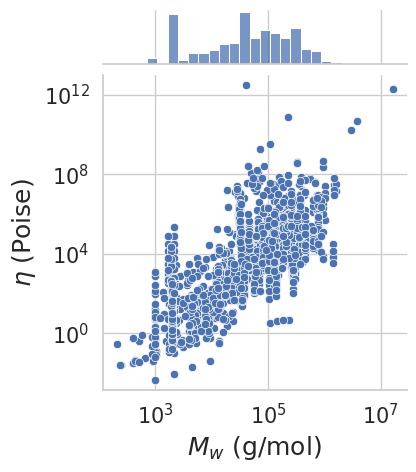

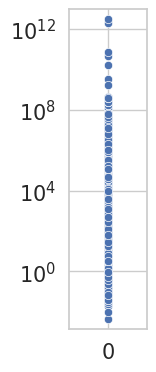

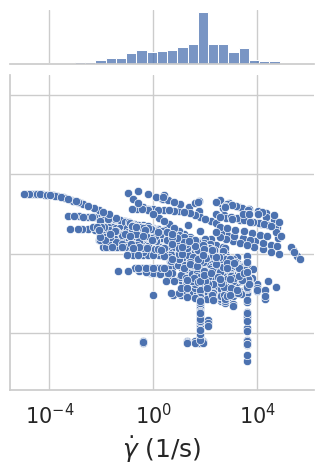

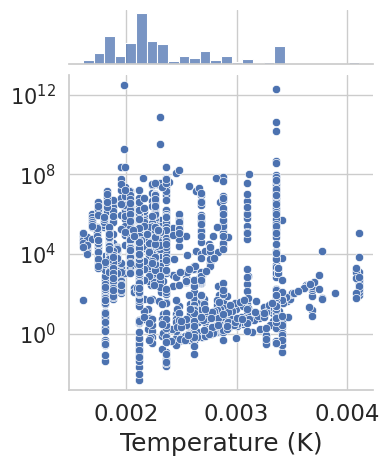

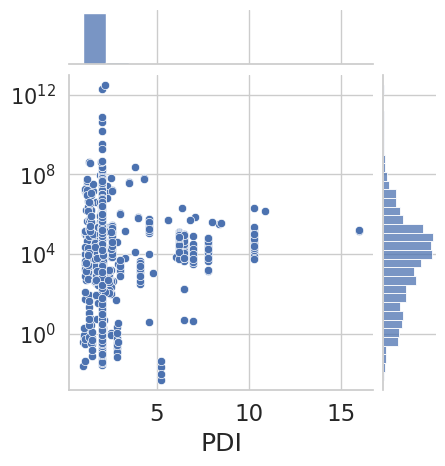

In [34]:
import seaborn as sns
import matplotlib.gridspec as gridspec
sns.set_theme()

sns.set(font_scale = 1.5, style = 'whitegrid')
y_lim = (np.min(yy) - 0.5, np.max(yy) + 0.5)

# ax1.scatter(M_scaler.inverse_transform(M_test), y_scaler.inverse_transform(y_test), edgecolors= 'black')
Mw_plot = sns.jointplot(data = pd.DataFrame({'Molecular Weight (g/mol)' : logMw.reshape(-1,), 'Melt Viscosity (Poise)': yy.reshape(-1,)}),
x = 'Molecular Weight (g/mol)', y = 'Melt Viscosity (Poise)', kind = 'scatter', height = 5)
Mw_plot.ax_marg_y.remove()
Mw_plot.ax_joint.set_xticks([3,5,7], [rf'$10^{i}$' for i in [3,5,7]], fontsize = 15)
Mw_plot.ax_joint.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = 15)
Mw_plot.set_axis_labels(r'$M_w$ (g/mol)', r'$\eta$ (Poise)')
Mw_plot.ax_joint.set(ylim = y_lim)

#plt.savefig('Paper_Fig/Mw_data.svg', dpi = 300)

plt.figure(figsize= (1,4.15))
#Zero Shear

zshear_df = pd.DataFrame({'Shear Rate (1/s)' : (shear[shear==0]).reshape(-1,), r'Melt Viscosity (Poise)': yy[shear == 0]})
for i in zshear_df.index:
    zshear_df.loc[i, ['Shear Rate (1/s)']] = zshear_df.loc[i, ['Shear Rate (1/s)']][0]
    zshear_df.loc[i, ['Melt Viscosity (Poise)']] = zshear_df.loc[i, ['Melt Viscosity (Poise)']][0]

zshear_plot = sns.scatterplot(data = zshear_df, x = 'Shear Rate (1/s)', y = 'Melt Viscosity (Poise)')
#zshear_plot.ax_marg_y.remove()
zshear_plot.set_xticks([0], ['0'], fontsize = 15)
zshear_plot.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize =15)
zshear_plot.set(xlabel = None, ylabel = None , ylim = y_lim)

#plt.savefig('Paper_Fig/zshear_data.svg', dpi = 300)

#Shear

shear_df = pd.DataFrame({'Shear Rate (1/s)' : np.log10(shear[shear>0]).reshape(-1,), r'Melt Viscosity (Poise)': yy[shear>0].reshape(-1,)})
for i in shear_df.index:
    shear_df.loc[i, ['Shear Rate (1/s)']] = shear_df.loc[i, ['Shear Rate (1/s)']][0]
    shear_df.loc[i, ['Melt Viscosity (Poise)']] = shear_df.loc[i, ['Melt Viscosity (Poise)']][0]


shear_plot = sns.jointplot(data = shear_df, x = 'Shear Rate (1/s)', y = 'Melt Viscosity (Poise)', kind = 'scatter', height = 5)
shear_plot.ax_marg_y.remove()
shear_plot.ax_joint.set_xticks(list(np.arange(-4,7,4)),  [r'$10^{-4}$'] + [rf'$10^{i}$' for i in list(np.arange(0,7,4))], fontsize = 15)
shear_plot.ax_joint.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,13,4))], fontsize =15)
shear_plot.set_axis_labels(r'$\dot{\gamma}$ (1/s)', r'$\eta$ (Poise)')
shear_plot.ax_joint.set(yticklabels=[], ylabel = None, ylim = y_lim)

#plt.savefig('Paper_Fig/shear_data.svg', dpi = 300)

#Temperature

temp_df = pd.DataFrame({'Temp': Temp.reshape(-1,), 'Visc': yy.reshape(-1,)})
for i in temp_df.index:
    temp_df.loc[i, ['Temp']] = temp_df.loc[i, ['Temp']][0]
    temp_df.loc[i, ['Visc']] = temp_df.loc[i, ['Visc']][0]

temp_plot = sns.jointplot(data = temp_df, x = 'Temp', y = 'Visc', kind = 'scatter', height = 5)
temp_plot.ax_marg_y.remove()
temp_plot.set_axis_labels(r'Temperature (K)', r'$\eta$ (Poise)')
temp_plot.ax_joint.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = 15)
temp_plot.ax_joint.set(ylim = y_lim, ylabel = None)

#plt.savefig('Paper_Fig/temp_data.svg', dpi = 300)

#PDI

PDI_df = pd.DataFrame({'PDI': PDI.reshape(-1,), 'Visc': yy.reshape(-1,)})
for i in PDI_df.index:
    PDI_df.loc[i, ['PDI']] = PDI_df.loc[i, ['PDI']][0]
    PDI_df.loc[i, ['Visc']] = PDI_df.loc[i, ['Visc']][0]

PDI_plot = sns.jointplot(data = PDI_df, x = 'PDI', y = 'Visc', kind = 'scatter', height = 5)
#PDI_plot.ax_marg_y.remove()
PDI_plot.set_axis_labels(r'PDI', r'$\eta$ (Poise)')
PDI_plot.ax_joint.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = 15)
PDI_plot.ax_joint.set(ylim = y_lim, ylabel = None)

#plt.savefig('Paper_Fig/pdi_data.svg', dpi = 300)

Reload Models

In [45]:
date = '2022-04-06'
models, history, gpr_models, gp_cv, NN_cv = load_models(date = date, data_type = 'split_custom_Mw_1187', NN_models = [create_ViscNN_concat])
#loaded_data = np.load(f'MODELS/{date}_split/data.npz', allow_pickle=True)
#XX, X_test, yy, y_test, M, M_test, S, S_test, T, T_test = loaded_data['XX'], loaded_data['X_test'], loaded_data['yy'], loaded_data['y_test'], loaded_data['M'], loaded_data['M_test'], loaded_data['S'], loaded_data['S_test'], loaded_data['T'],loaded_data['T_test']
model_reloaded = True

In [11]:
date = '2022-04-07'
models_f, history_f, gpr_models_f, gp_cv, NN_cv = load_models(date = date, data_type = 'full_aug', NN_models = [create_ViscNN_concat])
model_reloaded = True

In [12]:
Mw_samps, mw_ids = get_Mw_samples(data.copy(), full = True);
shear_samps, shear_ids = get_shear_samples(data.copy(), full = True)

In [34]:
import matplotlib.text as mtext


class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, r'\underline{' + orig_handle + '}', usetex=True, **self.text_props)
        handlebox.add_artist(title)
        return title

Zero Shear Visc. ANN Extrapolation: cis-1,4-poly(2-methyl-1,3-pentadiene) at 75.0 C
OME w.r.t. experimental points = 0.2167350798845291


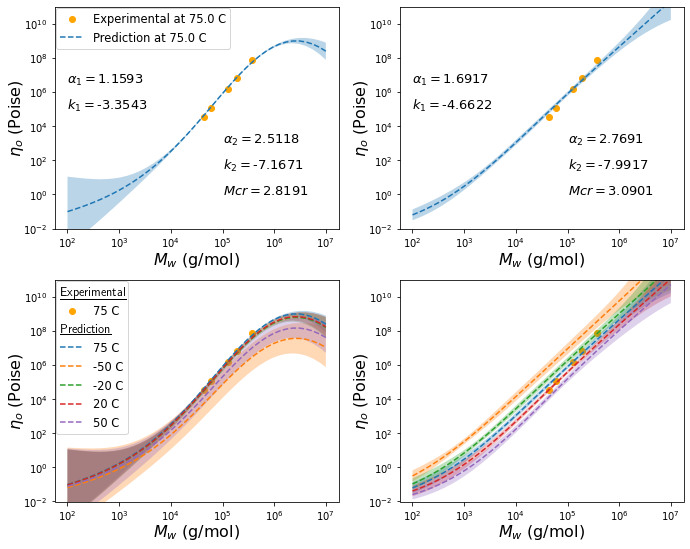

In [35]:
#Extrpolation Test Visualization for Paper - Mw
mid = 1137
#GPR
extrap_tests = Mw_test(Mw_samps, mid)
XX_ex, OH, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
Mw_ex = extrap_tests['exp'][0][~np.isnan((extrap_tests['exp'][1]))]
XX_ex = scaler.transform((XX_ex))
M_ex = M_scaler.transform(M_ex_og)
S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
T_ex = T_scaler.transform(1/(T_ex_og+273.15))
P_ex = P_scaler.transform(P_ex_og)
y_ax = (-2, 11)
temps = [-50, -20, 20, 50]

l = Mw_ex.shape[0]
test_pred, var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_ex, P_ex), axis = 1))
test_pred = y_scaler.inverse_transform(np.array(test_pred))


a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a[0] for a in test_pred]).astype(float))
#predicted_constants_gpr = pd.concat([predicted_constants_gpr, pd.DataFrame({'Sample': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)

fig = plt.figure(figsize = (10,8))

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

ax = [ax1, ax3, ax2, ax4]
tick = 0
fig.tight_layout(pad = 3)
exp_pred, _ = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex[:l], M_scaler.transform(np.array(Mw_ex).reshape(-1,1)), S_ex[:l], T_ex[:l], P_exp), axis =1))
exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
#fig.suptitle('Zero Shear Visc. GPR Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')
#print('Zero Shear Visc. GPR Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')

var = y_scaler.inverse_transform(np.array(var).reshape(-1, 1)) - y_scaler.data_min_

ax[tick].text(5, 3, r'$\alpha_2=$' + "{:1.4f}".format(a2), fontsize = 13)
ax[tick].text(5, 1.5, r'$k_2=$' + "{:1.4f}".format(k2), fontsize = 13)
ax[tick].text(5, -0, r'$Mcr=$' + "{:1.4f}".format(Mcr), fontsize = 13)
ax[tick].text(2, 6.5, r'$\alpha_1=$' + "{:1.4f}".format(a1), fontsize = 13)
ax[tick].text(2, 5, r'$k_1=$' + "{:1.4f}".format(k1), fontsize = 13)

for temp_test in [False, True]:

    ax[tick].set_xlabel(r'$M_w$ (g/mol)', fontsize = 16, labelpad = 0.5)
    ax[tick].set_ylabel(r'$\eta_o$ (Poise)', fontsize = 16, labelpad = -3)
    ax[tick].set_xticks(list(np.arange(2,8,1)),[rf'$10^{i}$' for i in list(np.arange(2,8,1))])
    ax[tick].set_yticks(list(np.arange(-2,11,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$'])
    
    ax[tick].axis(ymin = y_ax[0], ymax = y_ax[1])
    exp = ax[tick].scatter(Mw_ex, log_visc_ex, c = 'orange', label = f'Experimental at {T_ex_og[0][0]} C')
    #plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
    #plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, [i[0] for i in np.array(var).tolist()], fmt = '-')
    line1 = ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
    ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - var.reshape(-1,), test_pred.reshape(-1,) + var.reshape(-1,), alpha = 0.3 )

    t = []
    if temp_test:
        for i in temps:
            test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex), axis = 1))
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
            test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
            #plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, yerr= test_var,  label = f'Prediction at {T_ex_og[0][0] + i} C')
            t.append(ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C'))
            ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

        ax[tick].legend(['Experimental', exp, 'Prediction', line1[0], t[0][0], t[1][0], t[2][0], t[3][0]], ['', '75 C', '', '75 C'] + [str(temp) + ' C' for temp in temps],
            handler_map={str: LegendTitle({'fontsize': 12.5})}, prop={"size":11.5}, loc = 'upper left', borderaxespad = 0.1 )
    else:
        ax[tick].legend(loc = 'upper left', borderaxespad = 0.1 , prop={"size":11.5})
    tick += 1

#ANN
extrap_tests = Mw_test(Mw_samps, mid)
XX_ex, OH, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
Mw_ex = extrap_tests['exp'][0][~np.isnan((extrap_tests['exp'][1]))]
P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
XX_ex = scaler.transform((XX_ex))
M_ex = M_scaler.transform(M_ex_og)
S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
T_ex = T_scaler.transform(1/(T_ex_og+273.15))
P_ex = P_scaler.transform(P_ex_og)
#test_pred = m_NP.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])
y_ax = (-2, 11)
temps = [-50, -20, 20, 50]

tick = 2
test_pred, test_var,_ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_ex, P_ex])
l = Mw_ex.shape[0]
exp_pred, _,_ = predict_all_cv(models_f[0],[XX_ex[:l], M_scaler.transform(np.array(Mw_ex).reshape(-1,1)), S_ex[:l], T_ex[:l], P_exp])
exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a for a in test_pred]).astype(float))
#predicted_constants_ann = pd.concat([predicted_constants_ann, pd.DataFrame({'Sample': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)

#fig.suptitle('Zero Shear Visc. ANN Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')
print('Zero Shear Visc. ANN Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')


ax[tick].text(5, 3, r'$\alpha_2=$' + "{:1.4f}".format(a2), fontsize = 13)
ax[tick].text(5, 1.5, r'$k_2=$' + "{:1.4f}".format(k2), fontsize = 13)
ax[tick].text(5, -0, r'$Mcr=$' + "{:1.4f}".format(Mcr), fontsize = 13)
ax[tick].text(2, 6.5, r'$\alpha_1=$' + "{:1.4f}".format(a1), fontsize = 13)
ax[tick].text(2, 5, r'$k_1=$' + "{:1.4f}".format(k1), fontsize = 13)

for temp_test in [False, True]:    
    ax[tick].set_xlabel(r'$M_w$ (g/mol)', fontsize = 16, labelpad = 0.5)
    ax[tick].set_ylabel(r'$\eta_o$ (Poise)', fontsize = 16, labelpad = -3)
    ax[tick].set_xticks(list(np.arange(2,8,1)),[rf'$10^{i}$' for i in list(np.arange(2,8,1))])
    ax[tick].set_yticks(list(np.arange(-2,11,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$'])
    
    # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    # ax[tick].text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
    # ax[tick].text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
    exp = ax[tick].scatter(Mw_ex, log_visc_ex, c = 'orange', label = f'Experimental at {T_ex_og[0][0]} C')
    ax[tick].axis(ymin = y_ax[0], ymax = y_ax[1])
    
    #plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
    #plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0]} C')


    line1 = ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
    ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )
    t = []
    if temp_test:
        for i in temps:
            test_pred, test_var, _ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex])
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
            test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
            t.append(ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C'))
            ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

        #ax[tick].legend(['Experimental', exp, 'Prediction', line1[0], t[0][0], t[1][0], t[2][0], t[3][0]], ['', '75 C', '', '75 C'] + [str(temp) + ' C' for temp in temps],
        #    handler_map={str: LegendTitle({'fontsize': 12.5})}, prop={"size":11.5}, loc = 'upper left', borderaxespad = 0.1 )
    else:
        #ax[tick].legend(loc = 'upper left', borderaxespad = 0.1 , prop={"size":11.5})
        pass
    tick += 1

# ax1.annotate('(A)', (6.75,-1.5), fontsize = 14, weight = 'bold')
# ax2.annotate('(C)', (6.75,-1.5), fontsize = 14, weight = 'bold')
# ax3.annotate('(B)', (6.75,-1.5), fontsize = 14, weight = 'bold')
# ax4.annotate('(D)', (6.75,-1.5), fontsize = 14, weight = 'bold')
# ax2 = plt.subplot(2,2,2)
# ax3 = plt.subplot(2,2,3)
# ax4 = plt.subplot(2,2,4)

# plt.savefig('Paper_Fig/Mw_extrap_cleaned.pdf', dpi = 300)
# plt.savefig('Paper_Fig/Mw_extrap_cleaned.svg', dpi = 300)


In [ ]:


#Extrpolation Test Visualization for Paper - Shear
sid = 
try:
    extrap_tests = shear_test(shear_samps, sid)
    XX_ex, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
    sample = extrap_tests['sample']
    log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
    shear_exp = np.power(10,extrap_tests['exp'][0])[~np.isnan((extrap_tests['exp'][1]))]
    #print(shear_exp)
    P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
    P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
except:
    print(f'Test failed for {sample}.')
    continue
#The inputs for the ML model to predict
#print(S_ex_og)
XX_ex = scaler.transform((XX_ex))
M_ex = M_scaler.transform(M_ex_og)
S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
T_ex = T_scaler.transform(1/(T_ex_og+273.15))
P_ex = P_scaler.transform(P_ex_og)
temps = [-50, -20, 20, 50]
y_min = min(log_visc_ex) - 2.5
y_max = max(log_visc_ex) + 2

fig = plt.figure(figsize = (7,10))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
ax = [ax1, ax2]
tick = 0
test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_ex, P_ex), axis = 1))
l = shear_exp.shape[0]
exp_pred, _ = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex[:l], M_ex[:l], S_scaler.transform(S_trans.transform(np.array(shear_exp).reshape(-1,1))), T_ex[:l], P_exp), axis = 1))
exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)


test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
# a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a for a in test_pred]).astype(float))
# predicted_constants_ann = pd.concat([predicted_constants_ann, pd.DataFrame({'Polymer': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)
n_0, tau, n  = fit_shear(np.array([a[0] for a in S_ex_og][:30]).astype(float), np.array([a for a in test_pred][30]).astype(float))
shear_predicted_constants_gpr = pd.concat([shear_predicted_constants_gpr, pd.DataFrame({'Sample': [sample], 'z_shear': [n_0], 'tau': [tau], 'n':[n]})], ignore_index = True)

fig.suptitle('Shear Visc. ANN Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')
ax[0].text(-2, y_max - 0.2, r'$\eta_0=$' + "{:1.4f}".format(n_0))
ax[0].text(-2, y_max -1.2 , r'$k_2=$' + "{:1.4f}".format(tau))
ax[0].text(-2, y_max - 2.2, r'$Mcr=$' + "{:1.4f}".format(n))


for temp_test in [False, True]:    
    ax[tick].set_xlabel(r'$Log M_w$ (g/mol)')
    ax[tick].set_ylabel(r'$Log \eta_o$ (Poise)')
    # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    # ax[tick].text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
    # ax[tick].text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
    ax[tick].scatter(np.log10(shear_exp), log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
    ax[tick].axis(ymin = y_min, ymax = y_max)
    
    #plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
    #plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0]} C')


    ax[tick].plot(np.log10(S_ex_og), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
    ax[tick].fill_between(np.log10(S_ex_og).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

    if temp_test:
        for i in temps:
            test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex), axis =1))
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
            test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
            ax[tick].plot(np.log10(S_ex_og), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C')
            ax[tick].fill_between(np.log10(S_ex_og).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

    ax[tick].legend()
    tick += 1



# get the actual experimental values of  the trial
try:
    extrap_tests = shear_test(shear_samps, sid)
    XX_ex, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
    sample = extrap_tests['sample']
    log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
    shear_exp = np.power(10,extrap_tests['exp'][0])[~np.isnan((extrap_tests['exp'][1]))]
    #print(shear_exp)
    P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
    P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
except:
    print(f'Test failed for {sample}.')
    continue
#The inputs for the ML model to predict
#print(S_ex_og)
XX_ex = scaler.transform((XX_ex))
M_ex = M_scaler.transform(M_ex_og)
S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
T_ex = T_scaler.transform(1/(T_ex_og+273.15))
P_ex = P_scaler.transform(P_ex_og)
temps = [-50, -20, 20, 50]
y_min = min(log_visc_ex) - 2.5
y_max = max(log_visc_ex) + 2

fig = plt.figure(figsize = (7,10))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
ax = [ax1, ax2]
tick = 0
test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_ex, P_ex), axis = 1))
l = shear_exp.shape[0]
exp_pred, _ = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex[:l], M_ex[:l], S_scaler.transform(S_trans.transform(np.array(shear_exp).reshape(-1,1))), T_ex[:l], P_exp), axis = 1))
exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)


test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
# a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a for a in test_pred]).astype(float))
# predicted_constants_ann = pd.concat([predicted_constants_ann, pd.DataFrame({'Polymer': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)
n_0, tau, n  = fit_shear(np.array([a[0] for a in S_ex_og][:30]).astype(float), np.array([a for a in test_pred][30]).astype(float))
shear_predicted_constants_gpr = pd.concat([shear_predicted_constants_gpr, pd.DataFrame({'Sample': [sample], 'z_shear': [n_0], 'tau': [tau], 'n':[n]})], ignore_index = True)

fig.suptitle('Shear Visc. ANN Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')
ax[0].text(-2, y_max - 0.2, r'$\eta_0=$' + "{:1.4f}".format(n_0))
ax[0].text(-2, y_max -1.2 , r'$k_2=$' + "{:1.4f}".format(tau))
ax[0].text(-2, y_max - 2.2, r'$Mcr=$' + "{:1.4f}".format(n))


for temp_test in [False, True]:    
    ax[tick].set_xlabel(r'$Log M_w$ (g/mol)')
    ax[tick].set_ylabel(r'$Log \eta_o$ (Poise)')
    # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    # ax[tick].text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
    # ax[tick].text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
    ax[tick].scatter(np.log10(shear_exp), log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
    ax[tick].axis(ymin = y_min, ymax = y_max)
    
    #plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
    #plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0]} C')


    ax[tick].plot(np.log10(S_ex_og), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
    ax[tick].fill_between(np.log10(S_ex_og).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

    if temp_test:
        for i in temps:
            test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex), axis =1))
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
            test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
            ax[tick].plot(np.log10(S_ex_og), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C')
            ax[tick].fill_between(np.log10(S_ex_og).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

    ax[tick].legend()
    tick += 1

In [32]:
os.makedirs(f'Extrapolation_Tests/{date}_{data_type}/Mw/GPR', exist_ok = True)
os.makedirs(f'Extrapolation_Tests/{date}_{data_type}/Mw/ANN', exist_ok = True)
os.makedirs(f'Extrapolation_Tests/{date}_{data_type}/shear/GPR', exist_ok = True)
os.makedirs(f'Extrapolation_Tests/{date}_{data_type}/shear/ANN', exist_ok = True)
os.makedirs(f'Extrapolation_Tests/{date}_{data_type}/low_shear/GPR', exist_ok = True)
os.makedirs(f'Extrapolation_Tests/{date}_{data_type}/low_shear/ANN', exist_ok = True)

In [17]:
matplotlib.rc_file_defaults()
predicted_constants_gpr = pd.DataFrame(columns = ['Sample', 'a1', 'a2', 'k1', 'k2', 'Mcr'])
for mid in mw_ids:
    extrap_tests = Mw_test(Mw_samps, mid)
    XX_ex, OH, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
    log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
    P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
    P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
    Mw_ex = extrap_tests['exp'][0][~np.isnan((extrap_tests['exp'][1]))]
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(M_ex_og)
    S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    P_ex = P_scaler.transform(P_ex_og)
    y_ax = (-2, 11)
    temps = [-50, -20, 20, 50]
    
    #print(XX_ex, M_ex, S_ex, T_ex, P_ex)

    l = Mw_ex.shape[0]
    test_pred, var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_ex, P_ex), axis = 1))
    test_pred = y_scaler.inverse_transform(np.array(test_pred))
    
    a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a[0] for a in test_pred]).astype(float))
    predicted_constants_gpr = pd.concat([predicted_constants_gpr, pd.DataFrame({'Sample': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)

    # fig = plt.figure(figsize = (7,10))
    # ax1 = plt.subplot(2,1,1)
    # ax2 = plt.subplot(2,1,2)
    # ax = [ax1, ax2]
    # tick = 0

    # exp_pred, _ = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex[:l], M_scaler.transform(np.array(Mw_ex).reshape(-1,1)), S_ex[:l], T_ex[:l], P_exp), axis =1))
    # exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
    # fig.suptitle('Zero Shear Visc. GPR Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')
    # var = y_scaler.inverse_transform(np.array(var).reshape(-1, 1)) - y_scaler.data_min_

    # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    # ax[0].text(5, 3, r'$\alpha_2=$' + "{:1.4f}".format(a2))
    # ax[0].text(5, 2, r'$k_2=$' + "{:1.4f}".format(k2))
    # ax[0].text(5, 1, r'$Mcr=$' + "{:1.4f}".format(Mcr))
    # ax[0].text(2.5, 4, r'$\alpha_1=$' + "{:1.4f}".format(a1))
    # ax[0].text(2.5, 3, r'$k_1=$' + "{:1.4f}".format(k1))

    # for temp_test in [False, True]:


    #     ax[tick].set_xlabel(r'$Log M_w$ (g/mol)')
    #     ax[tick].set_ylabel(r'$Log \eta_o$ (Poise)')
    #     ax[tick].axis(ymin = y_ax[0], ymax = y_ax[1])
    #     ax[tick].scatter(Mw_ex, log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
    #     #plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
    #     #plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, [i[0] for i in np.array(var).tolist()], fmt = '-')
    #     ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
    #     ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - var.reshape(-1,), test_pred.reshape(-1,) + var.reshape(-1,), alpha = 0.3 )

    #     if temp_test:
    #         for i in temps:
    #             test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex), axis = 1))
    #             test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    #             test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
    #             #plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, yerr= test_var,  label = f'Prediction at {T_ex_og[0][0] + i} C')
    #             ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C')
    #             ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

        
    #     ax[tick].legend()
    #     tick += 1
    # sample = extrap_tests['sample']
    # plt.savefig(f'Extrapolation_Tests/{date}_{data_type}/Mw/GPR/{sample}_{mid}.jpg', bbox_inches='tight')
    # plt.close(fig)

/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt

In [19]:

predicted_constants_gpr

,Sample,a1,a2,k1,k2,Mcr
0,poly(prop-1-ene) at 200.0 C,0.859882,1.387335,-3.117488,-4.780992,3.153847
1,polyisobutylene at 25.0 C,1.015309,2.516045,-0.834815,-6.713392,3.917128
2,polyisobutylene at 100.0 C,0.719152,3.027158,-1.293299,-10.8843,4.155535
3,polyisobutylene at 150.0 C,0.454549,2.43489,0.635249,-8.312929,4.518504
4,polyisobutylene at 175.0 C,0.183976,2.578146,-0.48223,-9.513875,3.77235
...,...,...,...,...,...,...
283,"Poly(4-vinyl phenol), Poly(ethylene oxide) at ...",2.764534,-2.460211,-4.45864,19.840714,4.650821
284,"Poly(4-vinyl phenol), Poly(ethylene oxide) at ...",2.750574,-2.545723,-4.2449,20.2991,4.634181
285,"Poly(4-vinyl phenol), Poly(ethylene oxide) at ...",2.916779,-2.605645,-4.334091,20.780907,4.547821
286,"Polystyrene, Poly(2,6-dimethyl 1,4-phenylene o...",2.799248,-1.997085,-6.072321,18.116898,5.043273


In [22]:
with open('Data/gpr_pred_const.pickle', 'wb') as handle:
    pickle.dump(predicted_constants_gpr, handle)

In [63]:
predicted_constants_ann2 = pd.DataFrame(columns = ['Sample', 'a1', 'a2', 'k1', 'k2', 'Mcr'])
for mid in mw_ids:
    extrap_tests = Mw_test(Mw_samps, mid)
    XX_ex, OH, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
    log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
    Mw_ex = extrap_tests['exp'][0][~np.isnan((extrap_tests['exp'][1]))]
    P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
    P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(M_ex_og)
    S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    P_ex = P_scaler.transform(P_ex_og)
    y_ax = (-2, 11)
    temps = [-50, -20, 20, 50]

    # fig = plt.figure(figsize = (7,10))
    # ax1 = plt.subplot(2,1,1)
    # ax2 = plt.subplot(2,1,2)
    # ax = [ax1, ax2]
    # tick = 0
    test_pred, test_var,_ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_ex, P_ex])
    l = Mw_ex.shape[0]
    exp_pred, _,_ = predict_all_cv(models_f[0],[XX_ex[:l], M_scaler.transform(np.array(Mw_ex).reshape(-1,1)), S_ex[:l], T_ex[:l], P_exp])
    exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
    a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a for a in test_pred]).astype(float))
    _, a2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex)[:-5],test_pred[:-5])
    predicted_constants_ann2 = pd.concat([predicted_constants_ann2, pd.DataFrame({'Sample': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)

    # fig.suptitle('Zero Shear Visc. ANN Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')
    # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    # ax[0].text(5, 3, r'$\alpha_2=$' + "{:1.4f}".format(a2))
    # ax[0].text(5, 2, r'$k_2=$' + "{:1.4f}".format(k2))
    # ax[0].text(5, 1, r'$Mcr=$' + "{:1.4f}".format(Mcr))
    # ax[0].text(2.5, 4, r'$\alpha_1=$' + "{:1.4f}".format(a1))
    # ax[0].text(2.5, 3, r'$k_1=$' + "{:1.4f}".format(k1))

    #for temp_test in [False, True]:    
    #     ax[tick].set_xlabel(r'$Log M_w$ (g/mol)')
    #     ax[tick].set_ylabel(r'$Log \eta_o$ (Poise)')
    #     # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    #     # ax[tick].text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
    #     # ax[tick].text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
    #     ax[tick].scatter(Mw_ex, log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
    #     ax[tick].axis(ymin = y_ax[0], ymax = y_ax[1])
        
    #     #plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
    #     #plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0]} C')


    #     ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
    #     ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

    #     if temp_test:
    #         for i in temps:
    #             test_pred, test_var, _ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex])
    #             test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    #             test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
    #             ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C')
    #             ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

    #     ax[tick].legend()
    #     tick += 1
    # sample = extrap_tests['sample']
    # plt.savefig(f'Extrapolation_Tests/{date}_{data_type}/Mw/ANN/{sample}_{mid}.jpg', bbox_inches='tight')
    # plt.close(fig)

/home/ayush/Melt_Viscosity_Predictor/MODELS/ViscNN.py:182: RuntimeWarning: Mean of empty slice
  means = np.nanmean(pred, axis = 0)
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covaria

0       3.01529
1      2.697368
2      2.615319
3      2.622803
4      2.687142
         ...   
283    1.828291
284    1.832996
285    1.857855
286    0.924911
287    0.935878
Name: a2, Length: 288, dtype: object

In [25]:
with open('Data/ann_pred_const_Mw1.pickle', 'wb') as handle:
    pickle.dump(predicted_constants_ann1, handle)

In [14]:
predicted_constants_gpr = pd.read_pickle('Data/gpr_pred_const.pickle')
predicted_constants_ann = pd.read_pickle('Data/ann_pred_const.pickle')

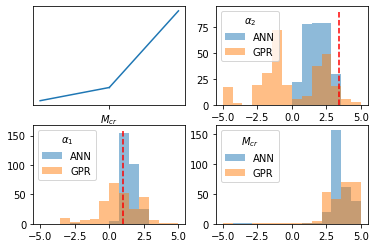

In [15]:
fig, ax = plt.subplots(2,2)

bins = np.linspace(-5, 5, 15)

ax[0,0].plot([0, 3], [0,3], color = 'tab:blue')
ax[0,0].plot([3,6], [3,6*3.4], color = 'tab:blue')
ax[0,0].set_yticks([])
ax[0,0].set_xticks([3])
ax[0,0].set_xticklabels([r'$M_{cr}$'])


ax[0,1].hist(predicted_constants_ann['a2'], bins = bins, alpha = 0.5 ,label = 'ANN')
#ax[0,1].hist([a[0] for a in predicted_constants_ann2['a2']], bins = bins, alpha = 0.5 ,label = 'ANN1')
ax[0,1].hist(predicted_constants_gpr['a2'], bins = bins, alpha = 0.5 ,label = 'GPR')
ax[0,1].plot([3.4, 3.4], [0, 90], '--', color = 'r')

ax[0,1].legend(title = r'$\alpha_2$')

ax[1,0].hist(predicted_constants_ann['a1'], bins = bins, alpha = 0.5 ,label = 'ANN')
ax[1,0].hist(predicted_constants_gpr['a1'], bins = bins, alpha = 0.5 ,label = 'GPR')
ax[1,0].plot([1, 1], [0, 160], '--', color = 'r')
ax[1,0].legend(title = r'$\alpha_1$')

ax[1,1].hist(predicted_constants_ann['Mcr'], bins = bins, alpha = 0.5 ,label = 'ANN')
ax[1,1].hist(predicted_constants_gpr['Mcr'], bins = bins, alpha = 0.5 ,label = 'GPR')
ax[1,1].legend(title = r'$M_{cr}$')

plt.savefig('Paper_Fig/Mw_const_pred.svg')

In [14]:
# Temperature WLF fitting for GPR
matplotlib.rc_file_defaults()
#predicted_constants_gpr = pd.DataFrame(columns = ['Sample', 'a1', 'a2', 'k1', 'k2', 'Mcr'])
WLF_constants_gpr = pd.DataFrame(columns = ['C1', 'C2', 'Tr'])
no_fit = 0
for mid in mw_ids:
    extrap_tests = Mw_test(Mw_samps, mid)
    XX_ex, OH, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
    log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
    P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
    P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
    Mw_ex = extrap_tests['exp'][0][~np.isnan((extrap_tests['exp'][1]))]
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(M_ex_og)
    S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    P_ex = P_scaler.transform(P_ex_og)
    y_ax = (-2, 11)
    temps = np.linspace(-50, 50, 20)
    
    #print(XX_ex, M_ex, S_ex, T_ex, P_ex)
    l = Mw_ex.shape[0]
    test_pred, var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_ex, P_ex), axis = 1))
    test_pred_og = y_scaler.inverse_transform(np.array(test_pred))
    
    #a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a[0] for a in test_pred]).astype(float))
    #predicted_constants_gpr = pd.concat([predicted_constants_gpr, pd.DataFrame({'Sample': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)
    a_T = []
    for i in temps:
        test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex), axis = 1))
        test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
        a_T.append(np.mean(test_pred - test_pred_og))

    #plt.scatter(temps, a_T)
    try:
        Tr, C1, C2 = fit_WLF(temps, np.array(a_T).reshape(-1,), T_ex_og.flatten()[0])
        WLF_constants_gpr = pd.concat([WLF_constants_gpr, pd.DataFrame({'Sample': extrap_tests['sample'], 'C1': [C1], 'C2':[C2], 'Tr':[Tr]})], ignore_index= True)
    except:
        no_fit += 1

print(no_fit)


2022-05-08 22:32:23.317749: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8c51b90
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimiz

22


In [13]:
# Temperature WLF fitting for ANN
matplotlib.rc_file_defaults()
#predicted_constants_ann = pd.DataFrame(columns = ['Sample', 'a1', 'a2', 'k1', 'k2', 'Mcr'])
WLF_constants_ann = pd.DataFrame(columns = ['C1', 'C2', 'Tr'])
no_fit = 0
for mid in mw_ids:
    extrap_tests = Mw_test(Mw_samps, mid)
    XX_ex, OH, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
    log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
    Mw_ex = extrap_tests['exp'][0][~np.isnan((extrap_tests['exp'][1]))]
    P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
    P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(M_ex_og)
    S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    P_ex = P_scaler.transform(P_ex_og)
    y_ax = (-2, 11)
    temps = np.linspace(-50, 50, 20)
    

    test_pred, test_var,_ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_ex, P_ex])
    l = Mw_ex.shape[0]
    exp_pred, _,_ = predict_all_cv(models_f[0],[XX_ex[:l], M_scaler.transform(np.array(Mw_ex).reshape(-1,1)), S_ex[:l], T_ex[:l], P_exp])
    exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
    test_pred_og = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
    #a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a for a in test_pred]).astype(float))
    #_, a2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex)[:-5],test_pred[:-5])
    #predicted_constants_ann2 = pd.concat([predicted_constants_ann2, pd.DataFrame({'Sample': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)

    a_T = []
    
    for i in temps:
        test_pred, test_var, _ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex])
        test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
        a_T.append(np.mean(test_pred - test_pred_og))

    #plt.scatter(temps, a_T)
    try:
        Tr, C1, C2 = fit_WLF(temps, np.array(a_T).reshape(-1,), T_ex_og.flatten()[0])
        WLF_constants_ann = pd.concat([WLF_constants_ann, pd.DataFrame({'Sample': extrap_tests['sample'], 'C1': [C1], 'C2':[C2], 'Tr':[Tr]})], ignore_index= True)
    except:
        no_fit += 1
    print(f'finished sample {mid}')

print(no_fit)

    

finished sample 1000.0
finished sample 1001.0
finished sample 1002.0


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1003.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1004.0
finished sample 1005.0


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1006.0


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1007.0


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1008.0


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1009.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1010.0


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1011.0
finished sample 1012.0
finished sample 1013.0
finished sample 1014.0
finished sample 1015.0
finished sample 1016.0
finished sample 1017.0
finished sample 1018.0
finished sample 1019.0
finished sample 1020.0


/home/ayush/Melt_Viscosity_Predictor/MODELS/ViscNN.py:182: RuntimeWarning: Mean of empty slice
  means = np.nanmean(pred, axis = 0)


finished sample 1021.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1022.0
finished sample 1023.0
finished sample 1024.0
finished sample 1025.0
finished sample 1026.0
finished sample 1027.0
finished sample 1028.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1029.0
finished sample 1030.0
finished sample 1031.0
finished sample 1032.0
finished sample 1033.0
finished sample 1034.0
finished sample 1035.0


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1036.0
finished sample 1037.0
finished sample 1038.0
finished sample 1039.0


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1040.0
finished sample 1041.0
finished sample 1042.0
finished sample 1043.0
finished sample 1044.0
finished sample 1045.0


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1046.0
finished sample 1047.0
finished sample 1048.0
finished sample 1049.0


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1050.0
finished sample 1051.0
finished sample 1052.0
finished sample 1053.0
finished sample 1054.0
finished sample 1055.0
finished sample 1056.0
finished sample 1057.0
finished sample 1058.0
finished sample 1059.0
finished sample 1060.0
finished sample 1061.0
finished sample 1062.0
finished sample 1063.0
finished sample 1064.0
finished sample 1065.0
finished sample 1066.0
finished sample 1067.0
finished sample 1068.0
finished sample 1069.0
finished sample 1070.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1071.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1072.0
finished sample 1073.0
finished sample 1074.0
finished sample 1075.0
finished sample 1076.0
finished sample 1077.0
finished sample 1078.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1079.0
finished sample 1080.0
finished sample 1081.0
finished sample 1082.0
finished sample 1083.0
finished sample 1084.0
finished sample 1085.0
finished sample 1086.0
finished sample 1087.0
finished sample 1088.0
finished sample 1089.0
finished sample 1090.0
finished sample 1091.0
finished sample 1092.0
finished sample 1093.0
finished sample 1094.0
finished sample 1095.0
finished sample 1096.0
finished sample 1097.0
finished sample 1098.0
finished sample 1099.0
finished sample 1100.0
finished sample 1101.0
finished sample 1102.0
finished sample 1103.0
finished sample 1104.0
finished sample 1105.0
finished sample 1106.0
finished sample 1107.0
finished sample 1108.0
finished sample 1109.0
finished sample 1110.0
finished sample 1111.0
finished sample 1112.0
finished sample 1113.0
finished sample 1114.0
finished sample 1115.0
finished sample 1116.0
finished sample 1117.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1118.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1119.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1120.0
finished sample 1121.0
finished sample 1122.0
finished sample 1123.0
finished sample 1124.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1125.0
finished sample 1126.0
finished sample 1127.0
finished sample 1128.0
finished sample 1129.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1130.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1131.0
finished sample 1132.0
finished sample 1133.0
finished sample 1134.0
finished sample 1135.0
finished sample 1136.0
finished sample 1137.0
finished sample 1138.0
finished sample 1139.0
finished sample 1140.0
finished sample 1141.0
finished sample 1142.0
finished sample 1143.0
finished sample 1144.0
finished sample 1145.0
finished sample 1146.0
finished sample 1147.0
finished sample 1148.0
finished sample 1149.0
finished sample 1150.0
finished sample 1151.0
finished sample 1152.0
finished sample 1153.0
finished sample 1154.0
finished sample 1155.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1156.0
finished sample 1157.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1158.0
finished sample 1159.0
finished sample 1160.0
finished sample 1161.0
finished sample 1162.0
finished sample 1163.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1164.0
finished sample 1165.0
finished sample 1166.0
finished sample 1167.0
finished sample 1168.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1169.0
finished sample 1170.0
finished sample 1171.0
finished sample 1172.0
finished sample 1173.0
finished sample 1174.0
finished sample 1175.0
finished sample 1176.0
finished sample 1177.0
finished sample 1178.0
finished sample 1179.0
finished sample 1180.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1181.0
finished sample 1182.0
finished sample 1183.0
finished sample 1184.0
finished sample 1185.0
finished sample 1186.0
finished sample 1187.0
finished sample 1188.0
finished sample 1189.0
finished sample 1190.0
finished sample 1191.0
finished sample 1192.0
finished sample 1193.0
finished sample 1194.0
finished sample 1195.0
finished sample 1196.0
finished sample 1197.0
finished sample 1198.0
finished sample 1199.0
finished sample 1200.0
finished sample 1201.0
finished sample 1202.0
finished sample 1203.0
finished sample 1204.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1205.0
finished sample 1206.0
finished sample 1207.0
finished sample 1208.0
finished sample 1209.0
finished sample 1210.0
finished sample 1211.0
finished sample 1212.0
finished sample 1213.0
finished sample 1214.0
finished sample 1215.0
finished sample 1216.0
finished sample 1217.0


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1218.0
finished sample 1219.0
finished sample 1220.0


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:38: RuntimeWarning: divide by zero encountered in true_divide
  out = (-1*C1*(T-Tr))/n
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1221.0
finished sample 1222.0
finished sample 1223.0
finished sample 1224.0
finished sample 1225.0
finished sample 1226.0
finished sample 1227.0
finished sample 1228.0
finished sample 1229.0
finished sample 1230.0
finished sample 1231.0
finished sample 1232.0
finished sample 1233.0
finished sample 1234.0
finished sample 1235.0
finished sample 1236.0
finished sample 1237.0
finished sample 1238.0
finished sample 1239.0
finished sample 1240.0
finished sample 1241.0
finished sample 1242.0
finished sample 1243.0
finished sample 1244.0
finished sample 1245.0
finished sample 1246.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1247.0
finished sample 1248.0
finished sample 1249.0
finished sample 1250.0
finished sample 1251.0
finished sample 1252.0
finished sample 1253.0
finished sample 1254.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1255.0
finished sample 1256.0
finished sample 1257.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1258.0
finished sample 1259.0
finished sample 1260.0
finished sample 1261.0
finished sample 1262.0
finished sample 1263.0
finished sample 1264.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1265.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1266.0
finished sample 1267.0
finished sample 1268.0
finished sample 1269.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1270.0
finished sample 1271.0
finished sample 1272.0
finished sample 1273.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1274.0
finished sample 1275.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1276.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1277.0
finished sample 1278.0
finished sample 1279.0
finished sample 1280.0
finished sample 1281.0
finished sample 1282.0
finished sample 1283.0
finished sample 1284.0
finished sample 1285.0


/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


finished sample 1286.0
finished sample 1287.0
47


In [14]:
with open('Data/ann_pred_const_wlf.pickle', 'wb') as handle:
    pickle.dump(WLF_constants_ann, handle)

#with open('Data/gpr_pred_const_wlf.pickle', 'wb') as handle:
 #   pickle.dump(WLF_constants_gpr, handle)

In [14]:
no_fit

175

In [16]:
shear_predicted_constants_ann = pd.DataFrame(columns = ['Sample', 'z_shear', 'n', 'tau'])
for sid in shear_ids:
    try:
        extrap_tests = shear_test(shear_samps, sid)
        XX_ex, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
        sample = extrap_tests['sample']
        log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
        shear_exp = np.power(10,extrap_tests['exp'][0])[~np.isnan((extrap_tests['exp'][1]))]
        #print(shear_exp)
        P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
        P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
    except:
        print(f'Test failed for {sample}.')
        continue
    #The inputs for the ML model to predict
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(M_ex_og)
    S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    P_ex = P_scaler.transform(P_ex_og)
    temps = [-50, -20, 20, 50]
    #test_pred = m_NP.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])


    # fig = plt.figure(figsize = (7,10))
    # ax1 = plt.subplot(2,1,1)
    # ax2 = plt.subplot(2,1,2)
    # ax = [ax1, ax2]
    tick = 0
    test_pred, test_var,_ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_ex, P_ex])
    
    l = shear_exp.shape[0]
    exp_pred, _,_ = predict_all_cv(models_f[0],[XX_ex[:l], M_ex[:l], S_scaler.transform(S_trans.transform(np.array(shear_exp).reshape(-1,1))), T_ex[:l], P_exp])
    exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
  
    
    test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)

    try:
        n_0, n, tau  = fit_shear(np.array([a[0] for a in S_ex_og][:30]).astype(float), np.array([a for a in test_pred][:30]).astype(float))
        shear_predicted_constants_ann = pd.concat([shear_predicted_constants_ann, pd.DataFrame({'Sample': [sample], 'z_shear': [n_0], 'tau': [tau], 'n':[n]})], ignore_index = True)
    except:
        print(f'Could not fit sample {sample}')
    # a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a for a in test_pred]).astype(float))
    # predicted_constants_ann = pd.concat([predicted_constants_ann, pd.DataFrame({'Polymer': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)

    # fig.suptitle('Shear Visc. ANN Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')
    
    # # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    # # ax[0].text(5, 3, r'$\alpha_2=$' + "{:1.4f}".format(a2))
    # # ax[0].text(5, 2, r'$k_2=$' + "{:1.4f}".format(k2))
    # # ax[0].text(5, 1, r'$Mcr=$' + "{:1.4f}".format(Mcr))
    # # ax[0].text(2.5, 4, r'$\alpha_1=$' + "{:1.4f}".format(a1))
    # # ax[0].text(2.5, 3, r'$k_1=$' + "{:1.4f}".format(k1))

    # for temp_test in [False, True]:    
    #     ax[tick].set_xlabel(r'$Log M_w$ (g/mol)')
    #     ax[tick].set_ylabel(r'$Log \eta_o$ (Poise)')
    #     # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    #     # ax[tick].text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
    #     # ax[tick].text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
    #     ax[tick].scatter(np.log10(shear_exp), log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
    #     ax[tick].axis(ymin = min(log_visc_ex) - 2.5, ymax = max(log_visc_ex) + 2)
    #     #plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
    #     #plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0]} C')


    #     ax[tick].plot(np.log10(S_ex_og), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
    #     ax[tick].fill_between(np.log10(S_ex_og).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

    #     if temp_test:
    #         for i in temps:
    #             test_pred, test_var, _ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex])
    #             test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    #             test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
    #             ax[tick].plot(np.log10(S_ex_og), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C')
    #             ax[tick].fill_between(np.log10(S_ex_og).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

    #     ax[tick].legend()
    #     tick += 1
    
    # plt.savefig(f'Extrapolation_Tests/{date}_{data_type}/shear/ANN/{sample}.jpg', bbox_inches='tight')
    # plt.close(fig)

/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-

Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for 

/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 899


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 1000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 2700


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 2939


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 3460


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 6500


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 10940


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 20000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 23099


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 24159


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 28599


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 34440


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 42000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 82000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 1039


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 1000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 2080


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 6399


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 8000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 8800


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 11400


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 15000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 18040


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 22139


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 23859


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 26500


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 41899


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 33039


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 45300


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 51880


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 62299


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 67139


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 69599


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-

Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 135.0765143464405 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 127.4171011470287 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 122.4685890834197 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 117.2439024390244 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 110.6163836163841 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 106.0720631786777 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 97.29893924783073 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 92.71428571428567 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 87.56338028169017 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 83.87732342007479 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 80.26586936522625 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 75.7738419618529 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 69.55129348795754 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 63.54688869412871 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 59.75563258232273 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 55.48588537211327 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 49.68907563025249 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 42.52999178307346 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,3-diol)-alt-(sebacic acid)] at 34.93905372894977 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-

Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 110.6477987421384 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 95.35748792270607 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 85.40188014101182 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 74.38041002277947 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 70.27518289251555 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 59.78777959629082 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 54.25321888412049 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 50.26444091149972 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 43.55422937208124 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 38.70158405723095 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 34.92529025744642 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 26.9016715830881 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 22.39951573849919 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 24.99706888128992 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 131.2163153070579 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 125.3739837398379 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 121.4543828264773 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 114.8627968337741 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 109.8125000000006 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 105.2161234991431 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 100.4123624047421 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 93.58354114713285 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 89.06896551724162 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 84.9545454545459 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 80.08246597277832 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 74.5177304964543 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 69.39130434782618 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 63.1280487804882 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 53.78769914783311 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 46.44947482796135 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 33.78260869565281 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 39.98793470546497 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 134.5785582255091 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 127.5449591280658 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 120.0481283422459 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 111.6489315307465 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 106.028792436614 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 99.78106508875777 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 93.43124221022117 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 87.00000000000102 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 84.3743922204219 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 81.50160771704242 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 77.8353221957043 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 71.5312500000012 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 67.27777777777794 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 61.34420015163107 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 56.35026138909654 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 52.70162481536283 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 142.254237288136 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 129.7397260273975 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 126.4565217391317 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 122.161290322582 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 106.8449612403101 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 98.05595288178387 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 85.2453290008134 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 80.64875701684048 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 74.24409448818994 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 69.12567882079196 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 65.44973138910291 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 62.10638297872384 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 58.95333082423878 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 54.63744427934705 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 52.34120250830023 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 141.2790042273377 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 134.202216066482 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 128.2738853503188 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 120.0481283422459 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 114.5219683655539 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 109.1490467937614 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 104.2455089820361 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 98.52485256950337 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 92.6716417910448 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 88.77194421657185 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 84.08502024291607 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 81.50160771704242 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 78.1146496815295 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 74.79179810725651 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 69.39130434782618 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 65.06055960138042 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 60.33333333333331 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 53.78769914783311 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 49.72228320526921 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 41.7751605995727 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 99.78106508875777 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 91.16184971098352 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 94.80650542118491 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 92.6716417910448 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 87.88379705401013 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 82.93220338983173 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 73.15384615384721 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 67.80370942812999 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 62.61643835616485 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 59.57918552036261 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 55.36932241250952 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 47.96069868995647 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 37.89178709904917 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 34.96089385474943 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 32.82524271844756 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 30.7190082644629 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 26.5923913043481 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 23.76985195154822 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 18.8596955658507 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(bisphenol A)-co-epichlorohydrin] at 90.0 C, Mw = 1891


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(bisphenol A)-co-epichlorohydrin] at 120.0 C, Mw = 1891


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/MODELS/ViscNN.py:182: RuntimeWarning: Mean of empty slice
  means = np.nanmean(pred, axis = 0)
/home/ayush/Melt_Viscosity_Predictor/MODELS/ViscNN.py:182: RuntimeWarning: Mean of empty slice
  means = np.nanmean(pred, axis = 0)
/home/ayush/Melt_Viscosity_Predictor/MODELS/ViscNN.py:182: RuntimeWarning: Mean of empty slice
  means = np.nanmean(pred, axis = 0)
/home/ayush/Melt_Viscosity_Predictor/MODELS/ViscNN.py:182: RuntimeWarning: Mean of empty sl

Could not fit sample poly(methylsiloxane), poly(dimethylsiloxane) at 25.0 C, Mw = 13300


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(methylsiloxane), poly(dimethylsiloxane) at 25.0 C, Mw = 13300


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-

Could not fit sample polyethene, bisphenol-A polycarbonate at 170.0 C, Mw = 857400


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


In [17]:
shear_predicted_constants_gpr = pd.DataFrame(columns = ['Sample', 'z_shear', 'n', 'tau'])
for sid in shear_ids:
    # get the actual experimental values of  the trial
    try:
        extrap_tests = shear_test(shear_samps, sid)
        XX_ex, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
        sample = extrap_tests['sample']
        log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
        shear_exp = np.power(10,extrap_tests['exp'][0])[~np.isnan((extrap_tests['exp'][1]))]
        P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
        P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
    except:
        print(f'Test failed for {sample}.')
        continue
    
    #The inputs for the ML model to predict
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(M_ex_og)
    S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    P_ex = P_scaler.transform(P_ex_og)
    temps = [-50, -20, 20, 50]
    y_min = min(log_visc_ex) - 2.5
    y_max = max(log_visc_ex) + 2

    # fig = plt.figure(figsize = (7,10))
    # ax1 = plt.subplot(2,1,1)
    # ax2 = plt.subplot(2,1,2)
    # ax = [ax1, ax2]
    # tick = 0
    test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_ex, P_ex), axis = 1))
    l = shear_exp.shape[0]
    exp_pred, _ = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex[:l], M_ex[:l], S_scaler.transform(S_trans.transform(np.array(shear_exp).reshape(-1,1))), T_ex[:l], P_exp), axis = 1))
    exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
  
    
    test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
    try:
        n_0, n, tau  = fit_shear(np.array([a[0] for a in S_ex_og][:30]).astype(float), np.array([a for a in test_pred][:30]).astype(float))
        shear_predicted_constants_gpr = pd.concat([shear_predicted_constants_gpr, pd.DataFrame({'Sample': [sample], 'z_shear': [n_0], 'tau': [tau], 'n':[n]})], ignore_index = True)
    except:
        print(f'Could not fit sample {sample}')
    # fig.suptitle('Shear Visc. ANN Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')
    # ax[0].text(-2, y_max - 0.2, r'$\eta_0=$' + "{:1.4f}".format(n_0))
    # ax[0].text(-2, y_max -1.2 , r'$k_2=$' + "{:1.4f}".format(tau))
    # ax[0].text(-2, y_max - 2.2, r'$Mcr=$' + "{:1.4f}".format(n))


    # for temp_test in [False, True]:    
    #     ax[tick].set_xlabel(r'$Log M_w$ (g/mol)')
    #     ax[tick].set_ylabel(r'$Log \eta_o$ (Poise)')
    #     # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    #     # ax[tick].text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
    #     # ax[tick].text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
    #     ax[tick].scatter(np.log10(shear_exp), log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
    #     ax[tick].axis(ymin = y_min, ymax = y_max)
        
    #     #plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
    #     #plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0]} C')


    #     ax[tick].plot(np.log10(S_ex_og), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
    #     ax[tick].fill_between(np.log10(S_ex_og).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

    #     if temp_test:
    #         for i in temps:
    #             test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex), axis =1))
    #             test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    #             test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
    #             ax[tick].plot(np.log10(S_ex_og), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C')
    #             ax[tick].fill_between(np.log10(S_ex_og).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

    #     ax[tick].legend()
    #     tick += 1
    
    # plt.savefig(f'Extrapolation_Tests/{date}_{data_type}/shear/GPR/{sample}.jpg', bbox_inches='tight')
    # plt.close(fig)

2022-05-06 12:34:05.445028: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7b8efc0
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosit

Could not fit sample poly[(butane-1,4-diol)-alt-(diethyl succinate)] at 180.0 C, Mw = 150000
Could not fit sample poly(L-lactide) at 180.0 C, Mw = 249999
Could not fit sample Poly (butylene terephthalate)  at 240.0 C, Mw = 55000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-

Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Could not fit sample Poly(hexano-6-lactam) at 260.0 C, Mw = 37000
Could not fit sample poly[(hexane-1,6-diamine)-alt-(adipic acid)] at 280.0 C, Mw = 33699


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(dodecano-12-lactam) at 200.0 C, Mw = 32000
Could not fit sample poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for p

/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(vinyl chloride) at 160.0 C, Mw = 127200
Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 899
Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 1000
Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 2700


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 2939
Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 3460
Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 6500
Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 10940
Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 20000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 23099
Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 24159
Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 28599
Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 34440
Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 42000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene isophthalate) at 280.0 C, Mw = 82000
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 1039
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 1000
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 2080
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 6399


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 8000
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 8800
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 11400
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 15000
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 18040


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 22139
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 23859
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 26500
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 41899
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 33039


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 45300
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 51880
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 62299
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 67139
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 69599


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 80999
Could not fit sample poly(ethylene terephthalate) at 280.0 C, Mw = 108340
Could not fit sample poly{[1,3-bis(4-fluorobenzoyl)benzene]-alt-[2-phenyl-4,5-bis(4-hydroxyphenyl)imidazole]} at 260.0 C, Mw = 183000
Could not fit sample poly{[1,3-bis(4-fluorobenzoyl)benzene]-alt-[2-phenyl-4,5-bis(4-hydroxyphenyl)imidazole]} at 285.0 C, Mw = 183000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly{[1,3-bis(4-fluorobenzoyl)benzene]-alt-[2-phenyl-4,5-bis(4-hydroxyphenyl)imidazole]} at 305.0 C, Mw = 183000
Could not fit sample poly{[1,3-bis(4-fluorobenzoyl)benzene]-alt-[2-phenyl-4,5-bis(4-hydroxyphenyl)imidazole]} at 335.0 C, Mw = 183000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-

Could not fit sample poly(oxycarbonyloxynonane-1,9-diyl) at 70.0 C, Mw = 4740
Could not fit sample poly(oxycarbonyloxynonane-1,9-diyl) at 70.0 C, Mw = 4400
Could not fit sample poly(oxycarbonyloxynonane-1,9-diyl) at 70.0 C, Mw = 3959
Could not fit sample polypropylene at 260.0 C, Mw = 138000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-

Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 110.6477987421384 C, Mw = 2000
Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 85.40188014101182 C, Mw = 2000
Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 74.38041002277947 C, Mw = 2000
Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 70.27518289251555 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 59.78777959629082 C, Mw = 2000
Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 54.25321888412049 C, Mw = 2000
Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 50.26444091149972 C, Mw = 2000
Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 43.55422937208124 C, Mw = 2000
Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 38.70158405723095 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 34.92529025744642 C, Mw = 2000
Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 26.9016715830881 C, Mw = 2000
Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 22.39951573849919 C, Mw = 2000
Could not fit sample poly[(triethylene glycol)-alt-(decanedioic acid)] at 24.99706888128992 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 131.2163153070579 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 125.3739837398379 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 121.4543828264773 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 114.8627968337741 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 109.8125000000006 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 105.2161234991431 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 100.4123624047421 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 93.58354114713285 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 89.06896551724162 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 84.9545454545459 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 80.08246597277832 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 74.5177304964543 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 69.39130434782618 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 63.1280487804882 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 53.78769914783311 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 46.44947482796135 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(oxydiethylene sebacate) at 33.78260869565281 C, Mw = 2000
Could not fit sample poly(oxydiethylene sebacate) at 39.98793470546497 C, Mw = 2000
Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 134.5785582255091 C, Mw = 2000
Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 127.5449591280658 C, Mw = 2000
Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 120.0481283422459 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 111.6489315307465 C, Mw = 2000
Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 106.028792436614 C, Mw = 2000
Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 99.78106508875777 C, Mw = 2000
Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 93.43124221022117 C, Mw = 2000
Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 87.00000000000102 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 84.3743922204219 C, Mw = 2000
Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 81.50160771704242 C, Mw = 2000
Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 77.8353221957043 C, Mw = 2000
Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 71.5312500000012 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 67.27777777777794 C, Mw = 2000
Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 61.34420015163107 C, Mw = 2000
Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 56.35026138909654 C, Mw = 2000
Could not fit sample poly[(propane-1,3-diol)-alt-(decanedioic acid)] at 52.70162481536283 C, Mw = 2000
Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 142.254237288136 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 129.7397260273975 C, Mw = 2000
Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 126.4565217391317 C, Mw = 2000
Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 122.161290322582 C, Mw = 2000
Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 106.8449612403101 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 98.05595288178387 C, Mw = 2000
Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 85.2453290008134 C, Mw = 2000
Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 80.64875701684048 C, Mw = 2000
Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 74.24409448818994 C, Mw = 2000
Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 69.12567882079196 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 65.44973138910291 C, Mw = 2000
Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 62.10638297872384 C, Mw = 2000
Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 58.95333082423878 C, Mw = 2000
Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 54.63744427934705 C, Mw = 2000
Could not fit sample poly[(butane-1,4-diol)-alt-(decanedioic acid)] at 52.34120250830023 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 141.2790042273377 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 134.202216066482 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 128.2738853503188 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 120.0481283422459 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 114.5219683655539 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 109.1490467937614 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 104.2455089820361 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 98.52485256950337 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 92.6716417910448 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 88.77194421657185 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 84.08502024291607 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 81.50160771704242 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 78.1146496815295 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 74.79179810725651 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 69.39130434782618 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 65.06055960138042 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 60.33333333333331 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 53.78769914783311 C, Mw = 2000
Could not fit sample poly(pentamethylene sebacate) at 49.72228320526921 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(pentamethylene sebacate) at 41.7751605995727 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 99.78106508875777 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 91.16184971098352 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 94.80650542118491 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 92.6716417910448 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 87.88379705401013 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 82.93220338983173 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 73.15384615384721 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 67.80370942812999 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 62.61643835616485 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 59.57918552036261 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 55.36932241250952 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 47.96069868995647 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 37.89178709904917 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 34.96089385474943 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 32.82524271844756 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 30.7190082644629 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 26.5923913043481 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 23.76985195154822 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 15.80157170923422 C, Mw = 2000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 18.8596955658507 C, Mw = 2000
Could not fit sample poly[(3,3'-oxydipropanol)-alt-(sebacic acid)] at 13.92257644762583 C, Mw = 2000
Could not fit sample poly((m-phenylenediamine)-alt-{5,5'-[(1-methylethane-1,1-diyl)bis(4,1-phenyleneoxy)]bis(isobenzofuran-1,3-dione)}) at 320.0 C, Mw = 30000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(bisphenol A)-co-epichlorohydrin] at 120.0 C, Mw = 1891


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-

Could not fit sample polyethene, poly(vinyl acetate) at 160.0 C, Mw = 57900
Could not fit sample poly[oxy(difluoromethylene)], poly[oxy(1,1,2,2-tetrafluoroethylene)] at 20.0 C, Mw = 21000


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(methyl methacrylate), poly{[1-(1,3-dicarboxypropyl)-3,5-dimethyl-2,6-dioxopiperidine-3,5-diyl]methylene} at 260.0 C, Mw = 80000
Could not fit sample poly(methyl methacrylate), poly{[1-(1,3-dicarboxypropyl)-3,5-dimethyl-2,6-dioxopiperidine-3,5-diyl]methylene} at 260.0 C, Mw = 80000
Could not fit sample poly(methylsiloxane), poly(dimethylsiloxane) at 25.0 C, Mw = 13300
Could not fit sample poly(methylsiloxane), poly(dimethylsiloxane) at 25.0 C, Mw = 13300


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly[(butane-1,4-diol)-alt-(isophthalic acid)], poly(oxybutane-1,4-diyloxy{5-[(sodiooxy)sulfonyl]isophthaloyl}) at 200.0 C, Mw = 23299
Could not fit sample poly[(butane-1,4-diol)-alt-(isophthalic acid)], poly(oxybutane-1,4-diyloxy{5-[(sodiooxy)sulfonyl]isophthaloyl}) at 200.0 C, Mw = 23299
Could not fit sample Poly(hexano-6-lactam), PPTA at 260.0 C, Mw = 37075
Could not fit sample Poly(hexano-6-lactam), PPTA at 260.0 C, Mw = 37149


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample Poly(hexano-6-lactam), PPTA at 260.0 C, Mw = 37300
Could not fit sample Poly(hexano-6-lactam), PPTA at 260.0 C, Mw = 37899
Could not fit sample poly(dodecano-12-lactam), PPTA at 200.0 C, Mw = 32399
Could not fit sample poly(dodecano-12-lactam), PPTA at 200.0 C, Mw = 33599


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly(dodecano-12-lactam), PPTA at 200.0 C, Mw = 34399
Could not fit sample poly(prop-1-ene), poly(hexano-6-lactam) at 260.0 C, Mw = 67750
Could not fit sample poly(prop-1-ene), poly(hexano-6-lactam) at 260.0 C, Mw = 103500
Could not fit sample poly(prop-1-ene), poly(hexano-6-lactam) at 260.0 C, Mw = 139250


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


In [20]:
with open('Data/shear_gpr_pred_const.pickle', 'wb') as handle:
    pickle.dump(shear_predicted_constants_gpr, handle)

with open('Data/shear_ann_pred_const.pickle', 'wb') as handle:
    pickle.dump(shear_predicted_constants_ann, handle)



In [22]:
shear_predicted_constants_gpr = pd.read_pickle('Data/shear_gpr_pred_const.pickle')
shear_predicted_constants_ann = pd.read_pickle('Data/shear_ann_pred_const.pickle')

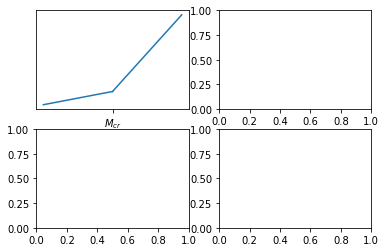

In [23]:
fig, ax = plt.subplots(2,2)

bins = np.linspace(-5, 5, 15)

ax[0,0].plot([0, 3], [0,3], color = 'tab:blue')
ax[0,0].plot([3,6], [3,6*3.4], color = 'tab:blue')
ax[0,0].set_yticks([])
ax[0,0].set_xticks([3])
ax[0,0].set_xticklabels([r'$M_{cr}$'])


ax[0,1].hist(np.log10(shear_predicted_constants_ann['z_shear']), bins = bins, alpha = 0.5 ,label = 'ANN')
#ax[0,1].hist([a[0] for a in predicted_constants_ann2['a2']], bins = bins, alpha = 0.5 ,label = 'ANN1')
ax[0,1].hist(np.log10(shear_predicted_constants_gpr['z_shear']), bins = bins, alpha = 0.5 ,label = 'GPR')
#ax[0,1].plot([3.4, 3.4], [0, 90], '--', color = 'r')

ax[0,1].legend(title = r'$\eta_o$')

ax[1,0].hist(shear_predicted_constants_ann['n'], bins = bins, alpha = 0.5 ,label = 'ANN')
ax[1,0].hist(shear_predicted_constants_gpr['n'], bins = bins, alpha = 0.5 ,label = 'GPR')
#ax[1,0].plot([1, 1], [0, 160], '--', color = 'r')
ax[1,0].legend(title = r'n')

ax[1,1].hist(np.log10(shear_predicted_constants_ann['tau']), bins = bins, alpha = 0.5 ,label = 'ANN')
ax[1,1].hist(np.log10(shear_predicted_constants_gpr['tau']), bins = bins, alpha = 0.5 ,label = 'GPR')
ax[1,1].legend(title = r'$\tau$')

In [46]:
shear_predicted_constants_gpr

,Sample,z_shear,n,tau
0,"polystyrene at 200.0 C, Mw = 274685",10665.596115,478.658898,0.627967
1,"polypropylene at 200.0 C, Mw = 236999",139481.659952,105099.795718,0.422099
2,"polypropylene at 200.0 C, Mw = 183000",55889.63516,45844.605741,0.505149
3,"poly(methyl methacrylate) at 220.0 C, Mw = 90000",14393.187378,1590218.560961,0.094289
4,"poly(methyl methacrylate) at 220.0 C, Mw = 90000",14393.187378,1590218.560961,0.094289
...,...,...,...,...
100,"polypropylene, poly(octa-1,7-diene) at 170.0 C...",7545778.66517,216805.888828,0.170882
101,"polyethene, bisphenol-A polycarbonate at 170.0...",209520.843478,497.906144,1.329159
102,"polyethene, bisphenol-A polycarbonate at 170.0...",146005.058863,0.002095,1.186396
103,"polyethene, bisphenol-A polycarbonate at 170.0...",12737.731439,13.220755,1.546279


Shear with Low and Zero Shear Rates

In [35]:

low_shear_samps = shear_samps.copy()
for samp in shear_ids:
    if np.prod(low_shear_samps.loc[low_shear_samps['SAMPLE_ID'] == samp, 'Shear_Rate']) != 0:
        low_shear_samps = low_shear_samps.drop(low_shear_samps.loc[low_shear_samps['SAMPLE_ID'] == samp].index, axis = 0)
low_shear_ids = list(low_shear_samps.agg({'SAMPLE_ID': 'unique'})[0])


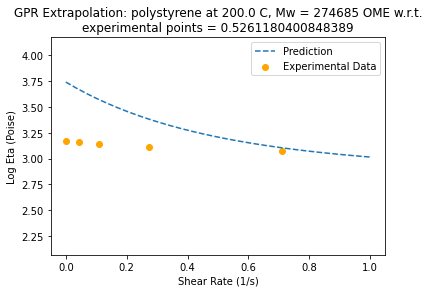

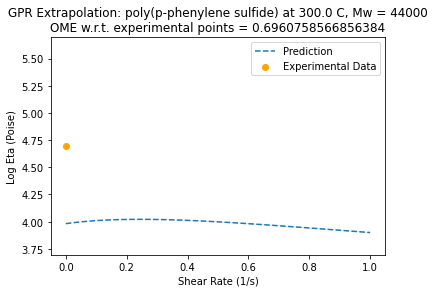

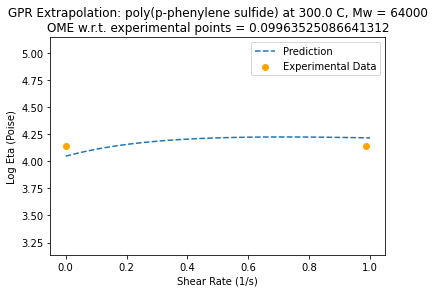

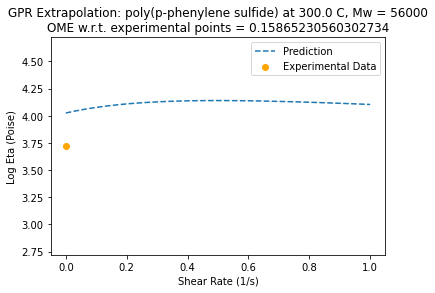

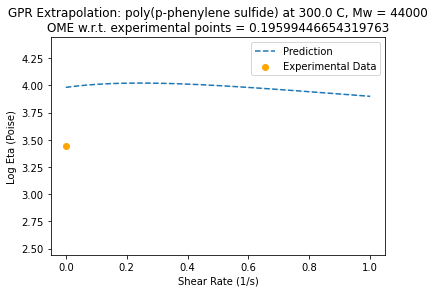

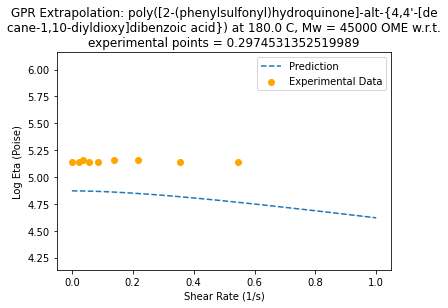

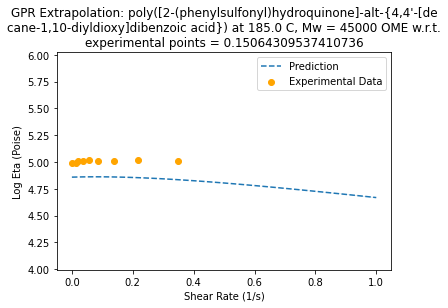

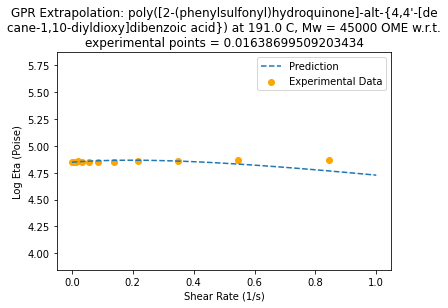

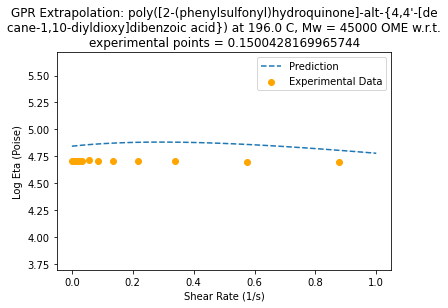

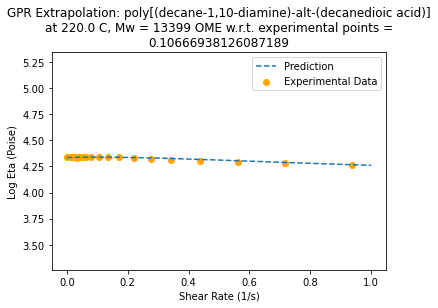

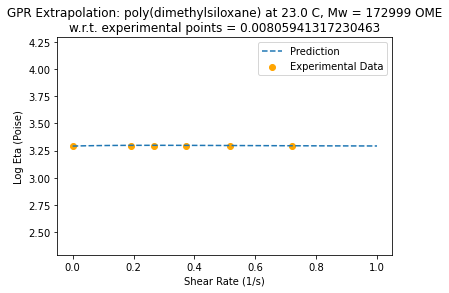

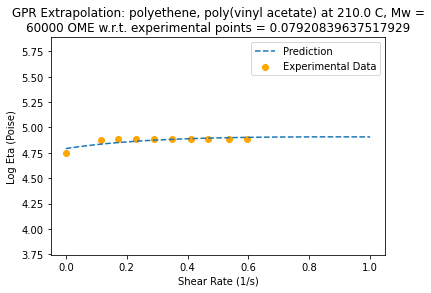

In [115]:
for ls_id in low_shear_ids:
    s_test = small_shear_test(low_shear_samps, ls_id)
    XX_ex, M_ex,S_ex_og,T_ex, P_ex = s_test['data_in']
    shear_exp = s_test['known'][0]
    log_visc_exp = s_test['known'][1]
    #XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(M_ex)
    S_ex_trans = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex+273.15))
    P_ex = P_scaler.transform(P_ex)
    temp_test = False
    y_min = min(log_visc_exp[np.where(shear_exp < 1)]) - 1
    y_max = max(log_visc_exp[np.where(shear_exp < 1)]) + 1
    l = shear_exp.shape[0]
    exp_pred, _ = gpr_models_f[3].predict_f_compiled(np.concatenate((XX_ex[:l], M_ex[:l], S_scaler.transform(S_trans.transform(np.array(shear_exp).reshape(-1,1))), T_ex[:l], P_ex[:l]), axis = 1))
    exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)

    test_pred, test_var = gpr_models_f[3].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex_trans, T_ex, P_ex), axis = 1))
    shear = [s[0] for s in S_ex_og]

    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    test_var = np.array(test_var*(y_scaler.data_max_ - y_scaler.data_min_)).reshape(-1,)

    plt.figure()
    plt.title("\n".join(wrap('GPR Extrapolation: ' + s_test['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_exp, exp_pred)}')))
    plt.plot(shear, np.array(test_pred).tolist(), '--', label = 'Prediction') #[i[0] for i in np.array(test_var).tolist()]
    plt.fill_between(S_ex_og.reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )
    plt.xlabel('Shear Rate (1/s)')
    plt.ylabel('Log Eta (Poise)')
    plt.scatter(shear_exp[np.where(shear_exp < 1)],  log_visc_exp[np.where(shear_exp < 1)], c = 'orange', label = 'Experimental Data')
    plt.ylim(y_min, y_max)
    plt.legend()

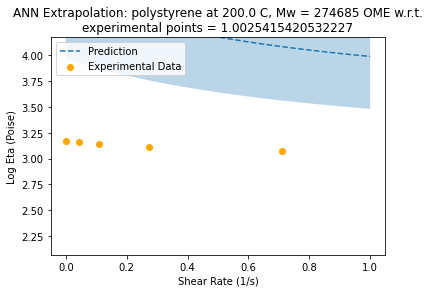

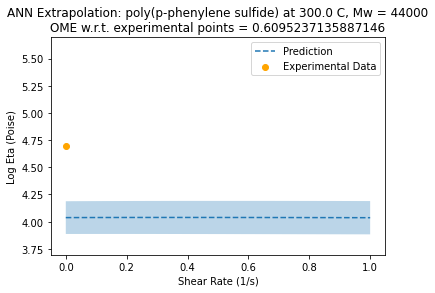

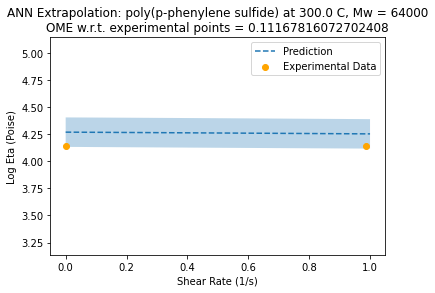

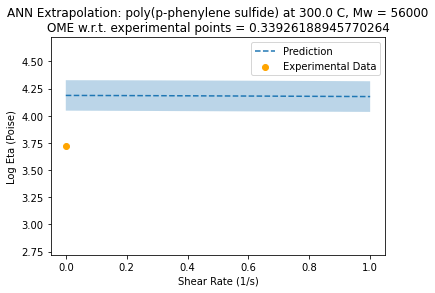

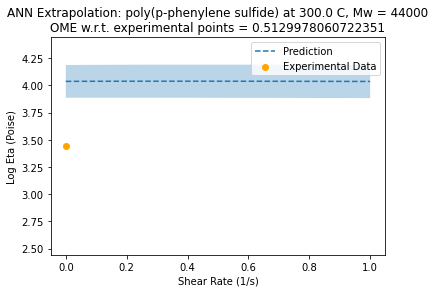

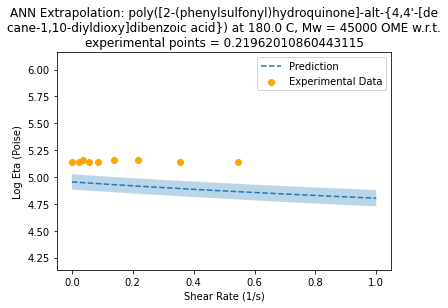

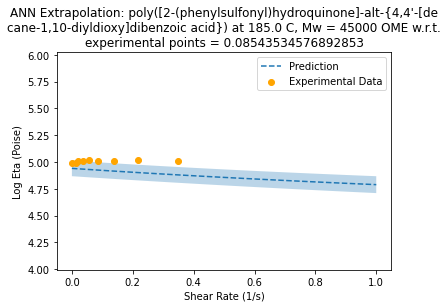

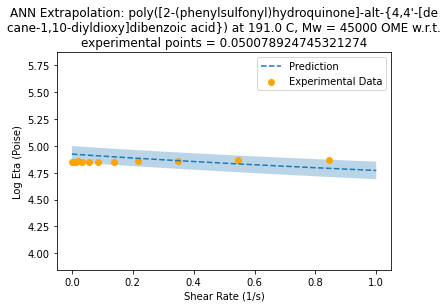

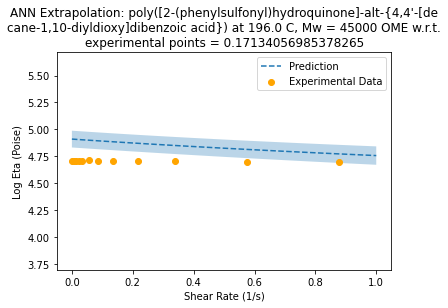

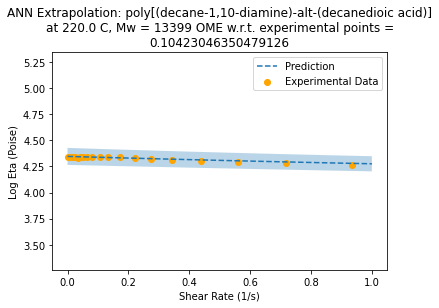

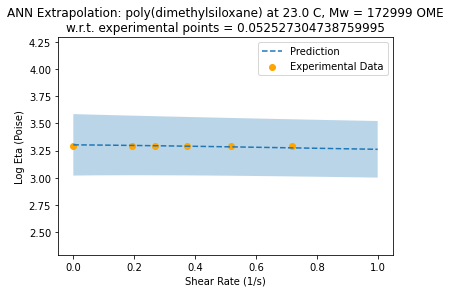

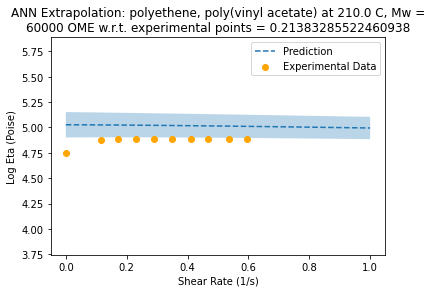

In [119]:
for ls_id in low_shear_ids:
    s_test = small_shear_test(low_shear_samps, ls_id)
    XX_ex, M_ex,S_ex_og,T_ex, P_ex = s_test['data_in']
    shear_exp = s_test['known'][0]
    log_visc_exp = s_test['known'][1]
    #XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(M_ex)
    S_ex_trans = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex+273.15))
    P_ex = P_scaler.transform(P_ex)
    temp_test = False
    y_min = min(log_visc_exp[np.where(shear_exp < 1)]) - 1
    y_max = max(log_visc_exp[np.where(shear_exp < 1)]) + 1
    
    l = shear_exp.shape[0]
    exp_pred, _,_ = predict_all_cv(models_f[0],[XX_ex[:l], M_ex[:l], S_scaler.transform(S_trans.transform(np.array(shear_exp).reshape(-1,1))), T_ex[:l], P_ex[:l]])
    exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)

    test_pred, test_var,_ = predict_all_cv(models_f[0], [XX_ex, M_ex, S_ex_trans, T_ex, P_ex])
    shear = [s[0] for s in S_ex_og]

    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)


    plt.figure()
    plt.plot(shear, test_pred, '--', label = 'Prediction')
    plt.title("\n".join(wrap('ANN Extrapolation: '+ s_test['sample']+ f'\nOME w.r.t. experimental points = {OME(log_visc_exp, exp_pred)}')))
    plt.fill_between(S_ex_og.reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )
    # if temp_test:
    #     for i in [1,3,5]:
    #         test_pred, test_var = predict_all_cv(models[1],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]]), gr_Mcr_ex])
    #         plt.errorbar(shear, test_pred, yerr= test_var)
    plt.ylim(y_min, y_max)
    plt.xlabel('Shear Rate (1/s)')
    plt.ylabel('Log Eta (Poise)')   
    plt.scatter(shear_exp[np.where(shear_exp < 1)], log_visc_exp[np.where(shear_exp < 1)], c = 'orange', label = 'Experimental Data')
    plt.legend()

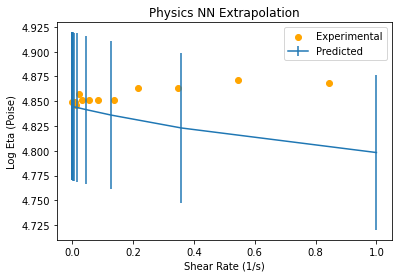

In [367]:
test_pred, test_var,_ = predict_all_cv(models[1], [XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in S_ex]

plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
plt.title('Physics NN Extrapolation')

if temp_test:
    for i in [1,3,5]:
        test_pred, test_var = predict_all_cv(models[1],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]]), gr_Mcr_ex])
        plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Shear Rate (1/s)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(shear_exp[np.where(shear_exp < 1)], log_visc_exp[np.where(shear_exp < 1)], c = 'orange')
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Prediction at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
    plt.legend(['Experimental','Predicted'])

Holistic Model Performance

In [46]:
os.listdir('Extrapolation_Tests/2022-03-23_full/Mw/ANN')

['cis-1,4-poly(2-methyl-1,3-pentadiene) at 75.0 C.jpg',
 'polyisobutylene at 25.0 C.jpg',
 'poly(prop-1-ene) at 200.0 C.jpg',
 'polybutadiene at 49.0 C.jpg',
 'polyisobutylene at 217.0 C.jpg',
 'hydrogenated polyisoprene at 130.0 C.jpg',
 'polybutadiene at -2.0 C.jpg',
 'polyethersulfone at 240.0 C.jpg',
 'polypropylene at 75.0 C.jpg',
 'polyisobutylene at 175.0 C.jpg',
 'polypropylene at 200.0 C.jpg',
 'polybutadiene at -28.0 C.jpg',
 'poly(dimethylsiloxane) at 20.0 C.jpg',
 'hydrogenated polyisoprene at 75.0 C.jpg',
 'polypropylene at 180.0 C.jpg',
 'polyisobutylene at 200.0 C.jpg',
 'polybutadiene at 25.0 C.jpg',
 'cis-1,4-polyisoprene at 75.0 C.jpg',
 'Linear HDPE at 150.0 C.jpg',
 'hydrogenated polyisoprene at 100.0 C.jpg',
 'polystyrene at 190.0 C.jpg',
 'poly(decamethylene adipate) at 109.0 C.jpg',
 'poly[(butane-1,4-diol)-alt-(isophthalic acid)], poly(oxybutane-1,4-diyloxy{5-[(sodiooxy)sulfonyl]isophthaloyl}) at 200.0 C.jpg',
 'poly[oxy(1,1,2,2,3,3-hexafluoropropane-1,3-diyl)] 